In [1]:
import pandas as pd
import joblib
import numpy as np
from scipy import sparse
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load datasets
n_samples = 1125678
embedding_dim = 768
sarcasm_feats = pd.read_csv("/content/drive/My Drive/cs3244/features/sarcasm_features.csv")
word_vectorizer = joblib.load("/content/drive/My Drive/cs3244/features/word_vectorizer.pkl")
char_vectorizer = joblib.load("/content/drive/My Drive/cs3244/features/char_vectorizer.pkl")
embeddings = np.memmap("/content/drive/My Drive/cs3244/features/embeddings_memmap.npy",dtype='float32',mode='r',shape=(n_samples, embedding_dim))


In [4]:
sarcasm_feats['text'] = sarcasm_feats['text'].fillna('')
#Transform text using pre-fitted TF-IDF vectorizers
X_word = word_vectorizer.transform(sarcasm_feats['text'])
X_char = char_vectorizer.transform(sarcasm_feats['text'])

In [5]:
# transform embeddings so collab don't crash :(
pca_components = 100    # reduce to 100 dimensions
batch_size_pca = 1024   # batch size for incremental PCA

ipca = IncrementalPCA(n_components=pca_components, batch_size=batch_size_pca)

for start in range(0, n_samples, batch_size_pca):
    end = min(start + batch_size_pca, n_samples)
    ipca.partial_fit(embeddings[start:end])

embeddings_pca = np.zeros((n_samples, pca_components), dtype=np.float32)
for start in range(0, n_samples, batch_size_pca):
    end = min(start + batch_size_pca, n_samples)
    embeddings_pca[start:end] = ipca.transform(embeddings[start:end])

In [6]:
X_sarcasm = sarcasm_feats.drop(columns=['label','text']).select_dtypes(include=np.number).values
# scale numeric features for sacarsm features
scaler = StandardScaler()
X_sarcasm_scaled = scaler.fit_transform(X_sarcasm)

X_sarcasm_sparse = sparse.csr_matrix(X_sarcasm_scaled)
X_emb_pca_sparse = sparse.csr_matrix(embeddings_pca)

# combine features with TF-IDF
X = sparse.hstack([X_emb_pca_sparse, X_word, X_char, X_sarcasm_sparse]).tocsr()
y = sarcasm_feats['label'].values

In [7]:
# train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Model training

In [8]:
# hyperparameter tuning
# Use a subset for tuning so collab won't crash
subset_size = min(1000, X_train.shape[0])
X_sub = X_train[:subset_size]
y_sub = y_train[:subset_size]

param_dist = {
    'C': [0.01, 0.1, 1, 10, 100]
}

svm = LinearSVC(max_iter=10000, random_state=42)
rand_search = RandomizedSearchCV(
    svm, param_distributions=param_dist,
    n_iter=5, scoring='f1_weighted', cv=3, verbose=2, n_jobs=-1
)
rand_search.fit(X_sub, y_sub)

print("Best params from tuning:", rand_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params from tuning: {'C': 0.1}


In [9]:
# final model
# Sample a fraction of the training set so collab won't crash
sample_frac = 0.3
sample_idx = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*sample_frac), replace=False)

X_train_sample = X_train[sample_idx]
y_train_sample = y_train[sample_idx]

svm_model = LinearSVC(
    C=rand_search.best_params_['C'],
    max_iter=10000,
    random_state=42
)

svm_model.fit(X_train_sample, y_train_sample)
y_pred = svm_model.predict(X_test)

Evaluation

In [10]:
# evaluate
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

F1 Score (weighted): 0.7200164283481462

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73    112568
           1       0.73      0.69      0.71    112568

    accuracy                           0.72    225136
   macro avg       0.72      0.72      0.72    225136
weighted avg       0.72      0.72      0.72    225136



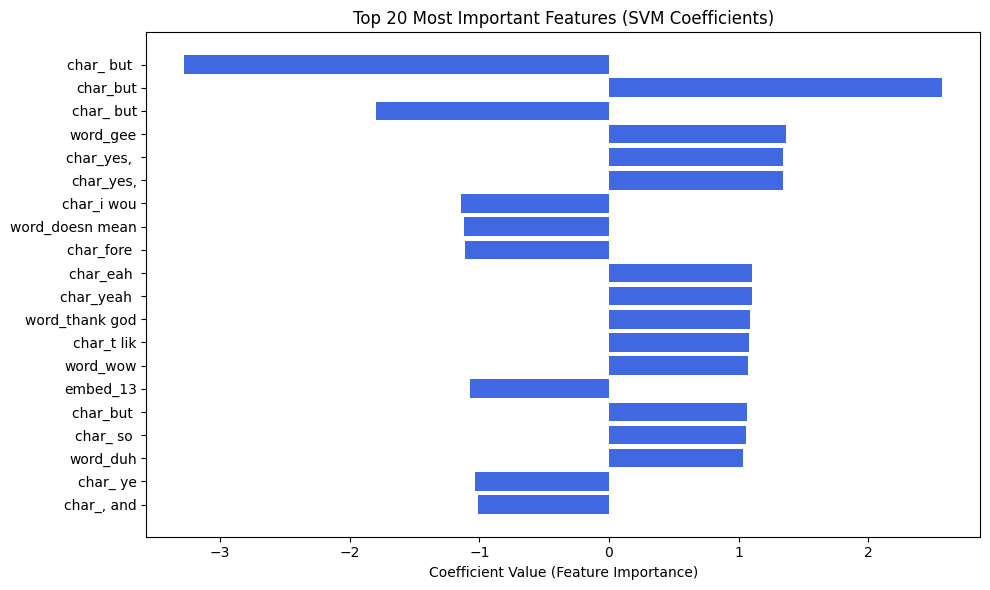

In [11]:
# feature importance
coef = svm_model.coef_[0]
importance = np.abs(coef)

word_features = word_vectorizer.get_feature_names_out()
char_features = char_vectorizer.get_feature_names_out()
handcraft_features = sarcasm_feats.drop(columns=['label','text']).select_dtypes(include=np.number).columns

feature_names = (
    [f"embed_{i}" for i in range(pca_components)] +
    [f"word_{w}" for w in word_features] +
    [f"char_{c}" for c in char_features] +
    [f"sarcasm_{f}" for f in handcraft_features]
)

top_idx = np.argsort(importance)[-20:][::-1]
top_features = [feature_names[i] for i in top_idx]
top_values = [coef[i] for i in top_idx]

plt.figure(figsize=(10, 6))
bars = plt.barh(top_features[::-1], top_values[::-1], color='royalblue')
plt.xlabel("Coefficient Value (Feature Importance)")
plt.title("Top 20 Most Important Features (SVM Coefficients)")
plt.tight_layout()
plt.show()

In [12]:
# error analysis
_, test_texts = train_test_split(
    sarcasm_feats['text'],
    test_size=0.2,
    random_state=42,
    stratify=sarcasm_feats['label']
)

test_texts = test_texts.reset_index(drop=True)

mis_idx = np.where(y_test != y_pred)[0]
print("Total misclassified:", len(mis_idx))

print("\n=== Misclassified Samples with Top Feature Contributions ===\n")

for i in range(min(5, len(mis_idx))):
    pos = mis_idx[i]

    text_ex = test_texts.iloc[pos]

    print(f"Text: {text_ex}")
    print(f"True label: {y_test[pos]}, Predicted: {y_pred[pos]}")
    print("-" * 50)

    sample_vector = X_test[pos].toarray().flatten()
    contrib = sample_vector * coef

    top_idx_sample = np.argsort(np.abs(contrib))[-10:][::-1]
    for feat_i in top_idx_sample:
        print(f"{feature_names[feat_i]}: {contrib[feat_i]:.4f}")

    print("=" * 80)

Total misclassified: 62982

=== Misclassified Samples with Top Feature Contributions ===

Text: What are the grottos?
True label: 1, Predicted: 0
--------------------------------------------------
embed_0: -0.1962
embed_4: -0.1589
embed_13: -0.1418
char_what : 0.0998
char_gro: -0.0787
char_at a: 0.0765
char_re th: 0.0696
char_ are: -0.0689
embed_36: -0.0621
char_e t: -0.0536
Text: Oh boy, here we go again.
True label: 0, Predicted: 1
--------------------------------------------------
word_oh boy: 0.3005
word_oh: 0.2612
char_ we : 0.1217
char_h b: 0.0978
char_ go : 0.0804
embed_12: 0.0770
word_boy: 0.0760
char_, h: 0.0740
char_ here: -0.0739
char_again: -0.0690
Text: So you've only listened to three Radiohead albums?
True label: 1, Predicted: 0
--------------------------------------------------
word_albums: 0.1539
embed_19: -0.1116
char_so : 0.0802
char_ed to: -0.0704
embed_9: -0.0632
embed_35: -0.0599
char_ene: -0.0582
char_list: 0.0559
embed_72: 0.0557
embed_12: 0.0541
Text: Need to c

In [13]:
model_file = "/content/drive/MyDrive/cs3244/models/svm_model.pkl"
joblib.dump(svm_model, model_file)
print(f"Saved trained model to {model_file}")

Saved trained model to /content/drive/MyDrive/cs3244/models/svm_model.pkl
